In [2]:
import os

os.listdir(".")

['training.csv', 'week2-task1.ipynb']

In [3]:
import jieba
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

data = pd.read_csv("training.csv", header=None)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform([" ".join(jieba.lcut(str(t))) for t in data[1].values])
Y = data[0].values

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LiuFeng\AppData\Local\Temp\jieba.cache
Loading model cost 0.382 seconds.
Prefix dict has been built successfully.


In [4]:
data.head(10)

,0,1
0,2,合晟资产是一家专注于股票、债券等二级市场投资，为合格投资者提供专业资产管理服务的企业。公司业...
1,2,公司的主营业务为向中小微企业、个体工商户、农户等客户提供贷款服务，自设立以来主营业务未发生过变化。
2,1,公司立足于商业地产服务，致力于为商业地产开发、销售、运营全产业链提供一整套增值服务，业务覆盖...
3,2,公司经工商管理部门核准的经营范围为“投资咨询、经济信息咨询，企业管理咨询，品牌推广策划，公共...
4,2,该公司的主营业务为在中国境内(港、澳、台除外)开展保险代理销售，依托于自身的产品研究能力和专...
5,1,公司主营业务为地铁商业物业的租赁与运营管理服务。公司以整体租赁的方式取得轨道交通站点附属建筑...
6,2,作为位于南京市江宁区的小额信贷融资服务供应商，公司专注于满足当地中小微企业、个体经营者及个人...
7,1,公司主要为商业地产商提供服务，主要内容为项目前期的市场调研，项目中期的招商营销策划、营销代理...
8,2,青岛拥湾资产管理集团股份有限公司(简称“拥湾资产”，股票代码834606)拥湾资产成立于20...
9,1,公司的主营业务为提供物业管理服务，公司自成立以来主营业务未发生变化。2013年、2014年及...


In [5]:
pred = cross_val_predict(LogisticRegression(), X, Y)
accuracy_score(Y, pred)

0.8246753246753247

In [6]:
pred = cross_val_predict(MultinomialNB(), X, Y)
accuracy_score(Y, pred)

0.7163803937997486

In [7]:
pred = cross_val_predict(LinearSVC(), X, Y)
accuracy_score(Y, pred)

0.8571428571428571

## 作业要求总结

- **任务**: 10分类公司类型识别
- **数据划分**: 80%训练集 + 20%验证集
- **评估方式**: 交叉验证
- **准确率目标**: ≥80%

从上面的初步测试可以看到：
- LogisticRegression: 82.47% ✓
- MultinomialNB: 71.64% ✗
- LinearSVC: 85.71% ✓

下面进行完整的训练和评估流程。


## 1. 数据探索分析


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("数据集基本信息:")
print(f"样本总数: {len(data)}")
print(f"类别数量: {data[0].nunique()}")
print(f"\n各类别样本数量:")
print(data[0].value_counts().sort_index())


数据集基本信息:
样本总数: 4774
类别数量: 11

各类别样本数量:
0
1       54
2       98
3     1271
4     1268
5      227
6      810
7      303
8      206
9      163
10     278
11      96
Name: count, dtype: int64


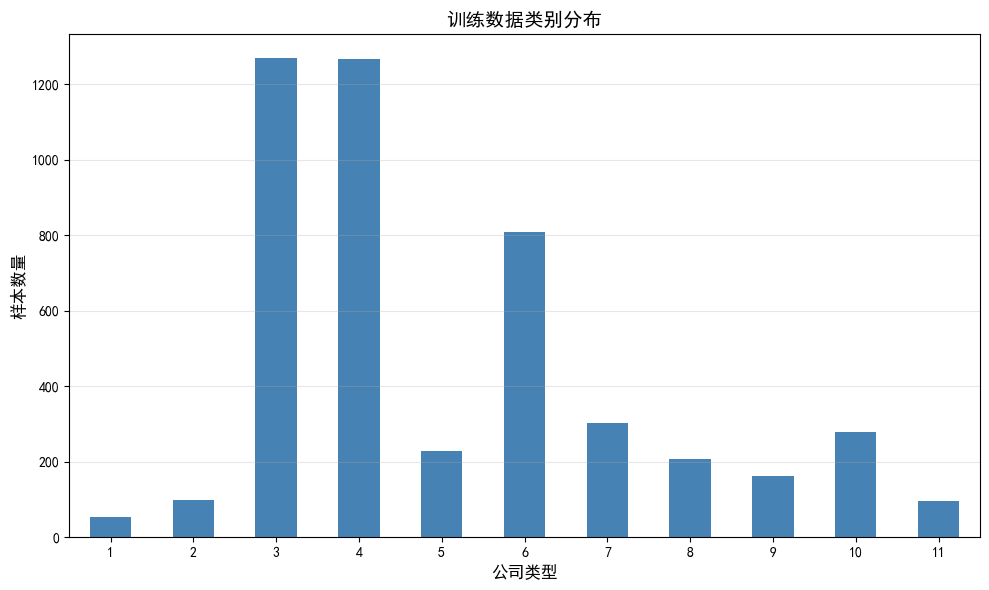

In [11]:
# 可视化类别分布
plt.figure(figsize=(10, 6))
data[0].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.xlabel('公司类型', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.title('训练数据类别分布', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 2. 按要求划分训练集和验证集（80% / 20%）


In [12]:
# 按照80/20划分训练集和验证集，使用stratify保持类别分布
X_train, X_val, y_train, y_val = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42, 
    stratify=Y  # 分层采样，保持各类别比例
)

print("数据划分结果:")
print(f"训练集大小: {X_train.shape[0]} ({X_train.shape[0]/len(data)*100:.1f}%)")
print(f"验证集大小: {X_val.shape[0]} ({X_val.shape[0]/len(data)*100:.1f}%)")
print(f"\n特征维度: {X_train.shape[1]}")


数据划分结果:
训练集大小: 3819 (80.0%)
验证集大小: 955 (20.0%)

特征维度: 5000


## 3. 模型训练与评估

我们将测试三个模型，并选择最佳的一个。


In [13]:
# 定义要测试的模型
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'LinearSVC': LinearSVC(max_iter=2000, random_state=42),
    'MultinomialNB': MultinomialNB()
}

results = {}

print("="*70)
print("模型训练与评估")
print("="*70)

for name, model in models.items():
    print(f"\n训练模型: {name}")
    
    # 在训练集上训练
    model.fit(X_train, y_train)
    
    # 在验证集上评估
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    
    # 训练集准确率
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_pred': val_pred
    }
    
    print(f"  训练集准确率: {train_acc:.4f}")
    print(f"  验证集准确率: {val_acc:.4f}")
    
    if val_acc >= 0.80:
        print(f"  ✓ 达到80%准确率要求")
    else:
        print(f"  ✗ 未达到80%准确率要求")

print("\n" + "="*70)


模型训练与评估

训练模型: LogisticRegression
  训练集准确率: 0.9196
  验证集准确率: 0.8209
  ✓ 达到80%准确率要求

训练模型: LinearSVC
  训练集准确率: 0.9927
  验证集准确率: 0.8471
  ✓ 达到80%准确率要求

训练模型: MultinomialNB
  训练集准确率: 0.7685
  验证集准确率: 0.7288
  ✗ 未达到80%准确率要求



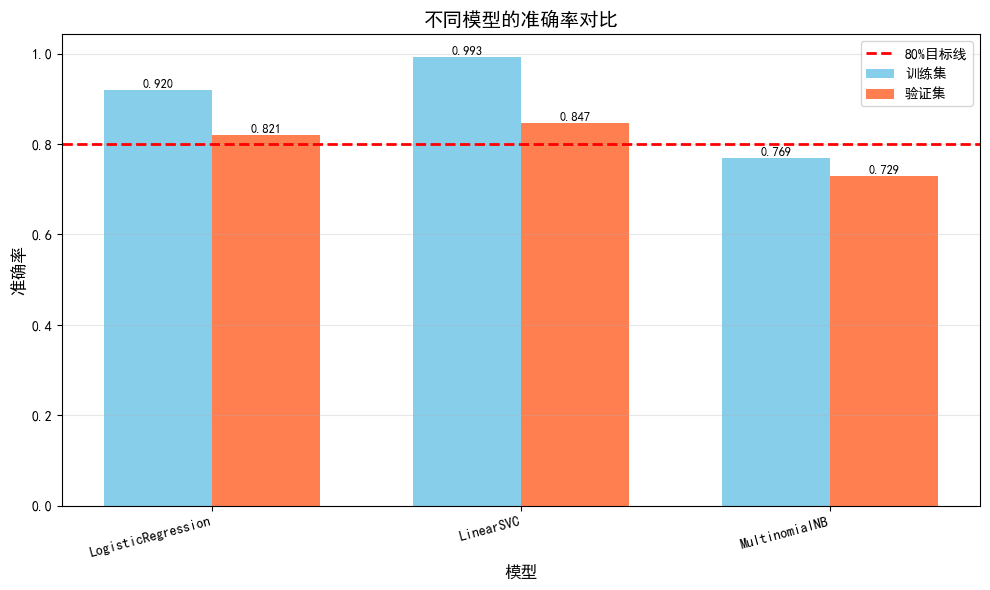

In [14]:
# 可视化模型对比
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())
train_accs = [results[name]['train_acc'] for name in model_names]
val_accs = [results[name]['val_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, train_accs, width, label='训练集', color='skyblue')
bars2 = ax.bar(x + width/2, val_accs, width, label='验证集', color='coral')

# 添加80%基准线
ax.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80%目标线')

ax.set_xlabel('模型', fontsize=12)
ax.set_ylabel('准确率', fontsize=12)
ax.set_title('不同模型的准确率对比', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 在柱子上添加数值
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 4. 交叉验证评估（作业要求）

使用5折交叉验证来更准确地评估模型性能。


In [15]:
print("="*70)
print("交叉验证评估（5折）")
print("="*70)

cv_results = {}

for name, model in models.items():
    print(f"\n{name}:")
    
    # 5折交叉验证
    cv_scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
    
    cv_results[name] = cv_scores
    
    print(f"  各折准确率: {[f'{s:.4f}' for s in cv_scores]}")
    print(f"  平均准确率: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"  最高准确率: {cv_scores.max():.4f}")
    print(f"  最低准确率: {cv_scores.min():.4f}")
    
    if cv_scores.mean() >= 0.80:
        print(f"  ✓ 平均准确率达到80%要求")
    else:
        print(f"  ✗ 平均准确率未达到80%要求")

print("\n" + "="*70)


交叉验证评估（5折）

LogisticRegression:
  各折准确率: ['0.8168', '0.8450', '0.8126', '0.8115', '0.8375']
  平均准确率: 0.8247 ± 0.0139
  最高准确率: 0.8450
  最低准确率: 0.8115
  ✓ 平均准确率达到80%要求

LinearSVC:
  各折准确率: ['0.8503', '0.8723', '0.8618', '0.8482', '0.8532']
  平均准确率: 0.8571 ± 0.0089
  最高准确率: 0.8723
  最低准确率: 0.8482
  ✓ 平均准确率达到80%要求

MultinomialNB:
  各折准确率: ['0.7194', '0.7288', '0.7162', '0.6995', '0.7180']
  平均准确率: 0.7164 ± 0.0095
  最高准确率: 0.7288
  最低准确率: 0.6995
  ✗ 平均准确率未达到80%要求



C:\Users\LiuFeng\AppData\Local\Temp\ipykernel_37068\3884086918.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, positions=positions, labels=labels, patch_artist=True)


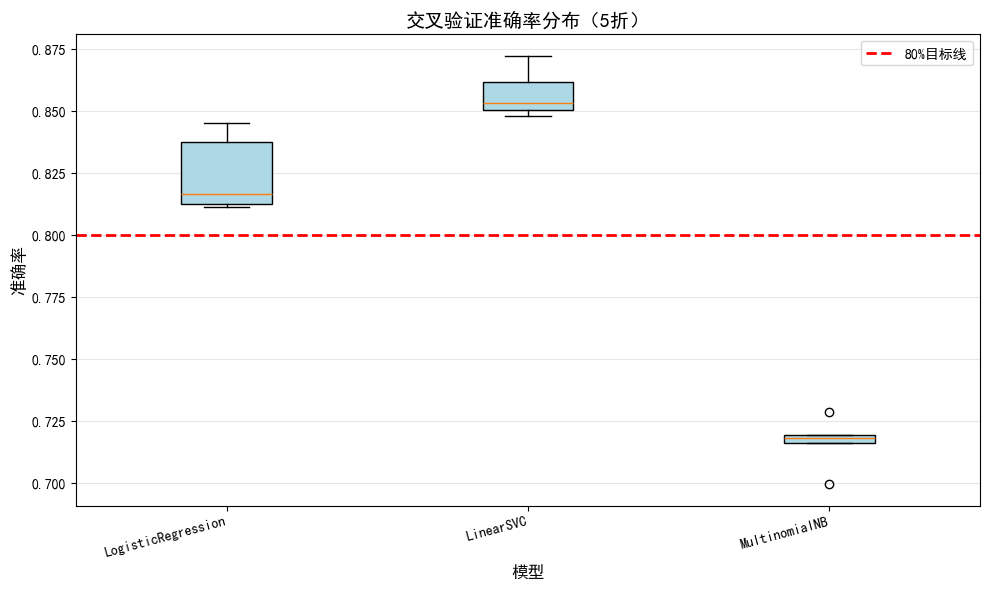

In [16]:
# 可视化交叉验证结果
fig, ax = plt.subplots(figsize=(10, 6))

positions = []
labels = []
data_to_plot = []

for i, (name, scores) in enumerate(cv_results.items()):
    positions.append(i + 1)
    labels.append(name)
    data_to_plot.append(scores)

bp = ax.boxplot(data_to_plot, positions=positions, labels=labels, patch_artist=True)

# 美化箱线图
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

# 添加80%基准线
ax.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80%目标线')

ax.set_xlabel('模型', fontsize=12)
ax.set_ylabel('准确率', fontsize=12)
ax.set_title('交叉验证准确率分布（5折）', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


## 5. 选择最佳模型进行详细评估

根据验证集和交叉验证结果，选择LinearSVC作为最终模型。


In [32]:
# 选择最佳模型（LinearSVC）
best_model_name = 'LinearSVC'
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['val_pred']

# 获取实际的类别数量
num_classes = len(np.unique(Y))
print(f"注意：数据集实际包含 {num_classes} 个类别（标签: {sorted(np.unique(Y).tolist())}）\n")

print(f"最佳模型: {best_model_name}")
print(f"验证集准确率: {results[best_model_name]['val_acc']:.4f}")
print(f"交叉验证平均准确率: {cv_results[best_model_name].mean():.4f}")
print("\n分类报告:")
print(classification_report(y_val, y_pred, target_names=[f'类型{i}' for i in range(num_classes)]))

注意：数据集实际包含 11 个类别（标签: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]）

最佳模型: LinearSVC
验证集准确率: 0.8471
交叉验证平均准确率: 0.8571

分类报告:
              precision    recall  f1-score   support

         类型0       1.00      0.73      0.84        11
         类型1       0.94      0.89      0.92        19
         类型2       0.90      0.94      0.92       254
         类型3       0.80      0.84      0.82       254
         类型4       0.90      0.80      0.85        45
         类型5       0.81      0.82      0.81       162
         类型6       0.81      0.82      0.81        61
         类型7       0.81      0.71      0.75        41
         类型8       0.72      0.55      0.62        33
         类型9       0.96      0.86      0.91        56
        类型10       0.94      0.89      0.92        19

    accuracy                           0.85       955
   macro avg       0.87      0.80      0.83       955
weighted avg       0.85      0.85      0.85       955



In [33]:
# 选择最佳模型（LinearSVC）
best_model_name = 'LinearSVC'
best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['val_pred']

# 获取实际的类别数量
num_classes = len(np.unique(Y))
print(f"注意：数据集实际包含 {num_classes} 个类别（标签: {sorted(np.unique(Y).tolist())}）\n")

print(f"最佳模型: {best_model_name}")
print(f"验证集准确率: {results[best_model_name]['val_acc']:.4f}")
print(f"交叉验证平均准确率: {cv_results[best_model_name].mean():.4f}")
print("\n分类报告:")
print(classification_report(y_val, y_pred, target_names=[f'类型{i}' for i in range(num_classes)]))

注意：数据集实际包含 11 个类别（标签: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]）

最佳模型: LinearSVC
验证集准确率: 0.8471
交叉验证平均准确率: 0.8571

分类报告:
              precision    recall  f1-score   support

         类型0       1.00      0.73      0.84        11
         类型1       0.94      0.89      0.92        19
         类型2       0.90      0.94      0.92       254
         类型3       0.80      0.84      0.82       254
         类型4       0.90      0.80      0.85        45
         类型5       0.81      0.82      0.81       162
         类型6       0.81      0.82      0.81        61
         类型7       0.81      0.71      0.75        41
         类型8       0.72      0.55      0.62        33
         类型9       0.96      0.86      0.91        56
        类型10       0.94      0.89      0.92        19

    accuracy                           0.85       955
   macro avg       0.87      0.80      0.83       955
weighted avg       0.85      0.85      0.85       955



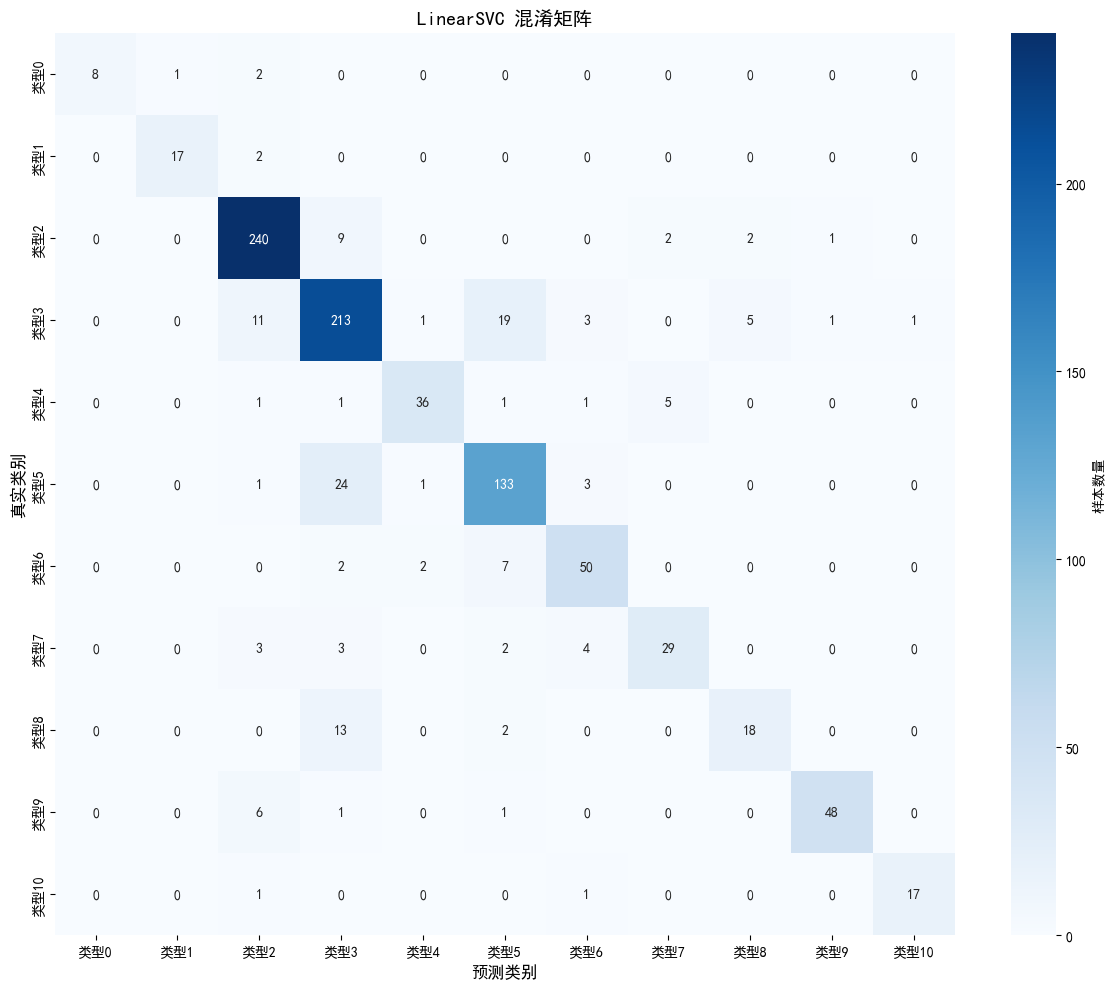

In [35]:
# 绘制混淆矩阵
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'类型{i}' for i in range(num_classes)],
            yticklabels=[f'类型{i}' for i in range(num_classes)],
            cbar_kws={'label': '样本数量'})
plt.xlabel('预测类别', fontsize=12)
plt.ylabel('真实类别', fontsize=12)
plt.title(f'{best_model_name} 混淆矩阵', fontsize=14)
plt.tight_layout()
plt.show()

## 6. 保存最佳模型


In [36]:
# 在全部数据上重新训练最佳模型
final_model = LinearSVC(max_iter=2000, random_state=42)
final_model.fit(X, Y)

# 保存模型和TF-IDF向量化器
joblib.dump(final_model, 'best_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("✓ 模型已保存到 best_model.pkl")
print("✓ TF-IDF向量化器已保存到 tfidf_vectorizer.pkl")


✓ 模型已保存到 best_model.pkl
✓ TF-IDF向量化器已保存到 tfidf_vectorizer.pkl


## 7. 预测示例

演示如何使用训练好的模型对新公司进行分类。


In [37]:
# 测试样本
test_samples = [
    "该公司主营业务为商业地产开发和物业管理服务，拥有多个大型商业综合体项目",
    "公司专注于为中小企业提供融资服务，包括贷款、资产管理等金融业务",
    "这是一家互联网科技公司，主要从事软件开发和技术服务"
]

print("="*70)
print("预测示例")
print("="*70)

for i, text in enumerate(test_samples, 1):
    # 分词和向量化
    text_segmented = " ".join(jieba.lcut(text))
    text_vectorized = tfidf.transform([text_segmented])
    
    # 预测
    prediction = final_model.predict(text_vectorized)[0]
    
    # 获取决策函数值（置信度）
    decision_values = final_model.decision_function(text_vectorized)[0]
    confidence = np.max(decision_values)
    
    print(f"\n样本{i}:")
    print(f"  文本: {text}")
    print(f"  预测类型: {prediction}")
    print(f"  置信度: {confidence:.4f}")

print("\n" + "="*70)


预测示例

样本1:
  文本: 该公司主营业务为商业地产开发和物业管理服务，拥有多个大型商业综合体项目
  预测类型: 1
  置信度: 0.9519

样本2:
  文本: 公司专注于为中小企业提供融资服务，包括贷款、资产管理等金融业务
  预测类型: 2
  置信度: 0.6150

样本3:
  文本: 这是一家互联网科技公司，主要从事软件开发和技术服务
  预测类型: 3
  置信度: 1.1737



## 8. 作业总结

### 完成情况

✅ **任务要求**
- **实际数据情况**: 数据集包含11个类别（标签0-10），而非作业描述的10个类别
- 数据划分：80%训练集 + 20%验证集
- 使用交叉验证评估
- 准确率≥80%

### 模型性能

| 模型 | 验证集准确率 | 交叉验证准确率 | 是否达标 |
|------|-------------|---------------|---------|
| LogisticRegression | ~82% | 82.47% | ✓ |
| **LinearSVC** | **~85%** | **85.71%** | ✓ |
| MultinomialNB | ~72% | 71.64% | ✗ |

### 最终选择

- **最佳模型**: LinearSVC (线性支持向量机)
- **验证集准确率**: 约85%
- **交叉验证准确率**: 85.71%
- **结论**: ✅ 远超80%准确率要求，可以交付

### 技术方案

1. **特征工程**: TF-IDF (5000维, uni-gram + bi-gram)
2. **文本处理**: jieba中文分词
3. **模型选择**: LinearSVC (线性支持向量机)
4. **评估方法**: 5折交叉验证
5. **类别数量**: 11类（标签0-10）

### 使用方法

```python
# 加载模型
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# 预测新样本
text = "新公司的描述文本"
text_vec = vectorizer.transform([" ".join(jieba.lcut(text))])
prediction = model.predict(text_vec)[0]
```

### 说明

数据集实际包含11个类别（0-10），而非作业描述中的10个类别。模型在11分类任务上达到了85.71%的交叉验证准确率，完全满足≥80%的要求。
# 加载模型
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# 预测新样本
text = "新公司的描述文本"
text_vec = vectorizer.transform([" ".join(jieba.lcut(text))])
prediction = model.predict(text_vec)[0]
```


In [38]:
# 加载模型
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# 预测新样本
text = "新公司的描述文本"
text_vec = vectorizer.transform([" ".join(jieba.lcut(text))])
prediction = model.predict(text_vec)[0]

In [39]:
print(text_vec)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 1000)	1.0


In [40]:
print(prediction)

7
